In [91]:
import simpy
import numpy as np
import random
from datetime import datetime, timedelta
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
virtual_queue = [
    {"flights": "BM2616", "time_slots": [4*3600], "capacity":[30]}, #Depature 05:45
    {"flights": "XC6333", "time_slots": [5.25*3600, 5.5*3600, 5.75*3600],"capacity":[20,20,5]}, #Depature 06:00
    {"flights": "OO2037", "time_slots": [5.5*3600, 5.75*3600, 6*3600], "capacity":[20,20,5]}, #Depature 06:15
    {"flights": "HP4524", "time_slots": [5.5*3600, 5.75*3600, 6*3600, 6.25*3600],"capacity":[10,20,5,10]}, #Depature 06:30
    {"flights": "DN7022", "time_slots": [6.5*3600, 6.25*3600, 6*3600],"capacity":[30,20,10]}, #Depature 06:45

    {"flights": "QX7315", "time_slots": [7*3600], "capacity":[20]}, #Depature 09:30
    {"flights": "SS2446", "time_slots": [9.25*3600, 9.5*3600], "capacity":[20, 20]}, #Depature 09:45
    {"flights": "ZI1701", "time_slots": [9.75*3600, 9.5*3600], "capacity":[20, 20]}, #Depature 10:00
    {"flights": "HC1255", "time_slots": [10*3600, 9.75*3600, 9.5*3600], "capacity":[20,20, 20]}, #Depature 10:15
    {"flights": "HF1818", "time_slots": [10.25*3600, 10*3600, ], "capacity":[20, 20]}, #Depature 10:30
    {"flights": "IG2596", "time_slots": [10.5*3600], "capacity":[40]} #Depature 10:45
]

In [93]:
def process_virtual_queue(passengers_data, virtual_queue):
    #Peak period 1: 04:15 - 05:15
    peak_periods1_start = 4.25*60*60
    peak_periods1_end = 5.25*60*60

    #Peak period 2: 07:30 - 09:00
    peak_periods2_start = 7.5*60*60
    peak_periods2_end = 9*60*60

    passengers_data["new_ArrivalTime"] = passengers_data["ArrivalTime"]
    passengers_data['Priority'] = 0
    
    # 遍历虚拟队列列表
    for flight_info in virtual_queue:
        flight_code = flight_info["flights"]
        time_slots = flight_info["time_slots"]
        capacities = flight_info["capacity"]

        # 获取符合条件的乘客
        eligible_passengers = passengers_data[((passengers_data['ArrivalTime'].between(peak_periods1_start, peak_periods1_end)) | 
                                           (passengers_data['ArrivalTime'].between(peak_periods2_start, peak_periods2_end))) & 
                                           (passengers_data['FlightNumber'] == flight_code)]

        # 随机选择乘客并分配到时间槽
        for i, passenger in eligible_passengers.iterrows():
            #如果所有时间槽都用完，可以在这里跳出循环
            if not time_slots:
                break

            time_slot = random.choice(time_slots)
            capacity = capacities[time_slots.index(time_slot)]

            # 检查时间槽容量是否用完
            if capacity == 0:
                continue

            # 生成随机到达时间，介于time_slot和time_slot + 15分钟之间
            random_arrival_time = random.uniform(time_slot, time_slot + 0.25 * 3600)

            # 进行相应的处理，例如更新到达时间、设置优先级等
            passengers_data.loc[i, 'new_ArrivalTime'] = random_arrival_time
            passengers_data.loc[i, 'Priority'] = 1  # 设置优先级

            # 减少相应时间槽的容量
            capacities[time_slots.index(time_slot)] -= 1

            # 如果时间槽容量用完，可以在这里移除该时间槽
            if capacities[time_slots.index(time_slot)] == 0:
                time_slots.remove(time_slot)
                
    passengers_data["new_ArrivalTime_formatted"] = passengers_data["new_ArrivalTime"].apply(lambda x: (datetime(1970, 1, 1) + timedelta(seconds=x)).strftime('%H:%M'))
    passengers_data["DepartureTime_formatted"] = passengers_data["DepartureTime"].apply(lambda x: (datetime(1970, 1, 1) + timedelta(seconds=x)).strftime('%H:%M'))

    return passengers_data

In [94]:

# 全局变量定义
waiting_time_list = []
waiting_passengers = 0
time_interval = 15 * 60
waiting_time_intervals = []
average_waiting_times = []
time_intervals_start = []

# 安检处理时间生成函数
def generate_processing_time():
    return random.expovariate(1 / 20.0)

# 重置全局变量的函数
def reset_globals():
    global waiting_time_list, waiting_passengers, waiting_time_intervals, average_waiting_times, time_intervals_start
    waiting_time_list = []
    waiting_passengers = 0
    waiting_time_intervals = [[]]
    average_waiting_times = []
    time_intervals_start = []

class SecurityLane:
    def __init__(self, env):
        self.env = env
        self.lane = simpy.Resource(env, capacity=1)
        self.virtual_queue = []

    def process_passenger(self, passenger_id, priority):
        arrival_time = self.env.now
        if priority == 1:
            self.virtual_queue.append((arrival_time, passenger_id))
            print(f"乘客{passenger_id}（优先级：{priority}）于{arrival_time}到达并进入虚拟队列")
            self.check_virtual_queue()
        else:
            print(f"乘客{passenger_id}（优先级：{priority}）于{arrival_time}到达并进入普通队列")
            with self.lane.request() as request:
                yield request
                yield self.env.process(self.security_check(arrival_time, passenger_id, priority))

    def security_check(self, arrival_time, passenger_id, priority):
        global waiting_passengers

        processing_start = self.env.now
        yield self.env.timeout(generate_processing_time())
        waiting_time = self.env.now - arrival_time
        waiting_time_list.append(waiting_time)
        waiting_passengers -= 1
        waiting_time_intervals[-1].append(waiting_time)
        print(f"乘客{passenger_id}（优先级：{priority}）在{processing_start}开始安检，于{self.env.now}完成（等待时间：{waiting_time}秒）")
        self.check_virtual_queue()

    def check_virtual_queue(self):
        if self.virtual_queue and not self.lane.count:
            arrival_time, passenger_id = self.virtual_queue.pop(0)
            self.env.process(self.security_check(arrival_time, passenger_id, 1))


def passenger_generator(env, security_lanes, passengers_data):
    for _, passenger in passengers_data.iterrows():
        passenger_id = passenger['Id']
        priority = passenger['Priority']
        arrival_time = passenger['new_ArrivalTime']
        yield env.timeout(arrival_time - env.now)
        shortest_lane = min(security_lanes, key=lambda x: len(x.lane.queue) + len(x.virtual_queue))
        env.process(shortest_lane.process_passenger(passenger_id, priority))


# 安检通道调整器
def adjust_security_lanes(env, security_lanes, security_data):
    for _, row in security_data.iterrows():
        time, lanes = row['Time'], row['Lanes']
        yield env.timeout(time - env.now)
        while len(security_lanes) < lanes:
            security_lanes.append(SecurityLane(env))
        while len(security_lanes) > lanes:
            security_lanes.pop()

# 平均等待时间计算器
def calculate_average_waiting_time(env):
    global time_intervals_start
    current_time = 0
    while True:
        yield env.timeout(time_interval)
        current_time += time_interval
        if waiting_time_intervals[-1]:
            avg_waiting_time = sum(waiting_time_intervals[-1]) / len(waiting_time_intervals[-1])
            average_waiting_times.append(avg_waiting_time)
        else:
            average_waiting_times.append(0)
        time_intervals_start.append(current_time - time_interval)
        waiting_time_intervals.append([])

# 单次模拟运行器
def run_simulation(sim_time, passengers_data, security_data):
    reset_globals()
    env = simpy.Environment()
    initial_lanes = security_data['Lanes'].iloc[0]
    security_lanes = [SecurityLane(env) for _ in range(initial_lanes)]
    env.process(passenger_generator(env, security_lanes, passengers_data))
    env.process(adjust_security_lanes(env, security_lanes, security_data))
    env.process(calculate_average_waiting_time(env))
    env.run(until=sim_time)
    df_avg_waiting_times = pd.DataFrame({'Average Waiting Time': average_waiting_times}, index=time_intervals_start)
    return df_avg_waiting_times

# 多次模拟运行器
def multiple_run_simulation(runs, sim_time, passengers_data, security_data):
    total_avg_waiting_times = None
    for i in range(runs):
        print(f"正在运行模拟 {i+1}/{runs}")
        average_waiting_time_df = run_simulation(sim_time, passengers_data, security_data)
        if total_avg_waiting_times is None:
            total_avg_waiting_times = average_waiting_time_df
        else:
            total_avg_waiting_times = total_avg_waiting_times.add(average_waiting_time_df, fill_value=0)
    overall_average = total_avg_waiting_times / runs
    return overall_average


In [95]:
# 数据导入
passengers_data = pd.read_csv('passengers_0.csv')
security_data = pd.read_csv('security.csv')
flights_data = pd.read_csv('flights.csv')
passengers_data = pd.merge(passengers_data, flights_data, left_on='FlightNumber', right_on='FlightNumber', how='left')
passengers_data = process_virtual_queue(passengers_data, virtual_queue).sort_values(by='new_ArrivalTime')
# 运行多次模拟
simulation_result_df = multiple_run_simulation(20, 40000, passengers_data, security_data)
print(simulation_result_df)

正在运行模拟 1/20
乘客7W4SUIW8P60C9EZHVKY7（优先级：0）于8233.11798182214到达并进入普通队列
乘客7W4SUIW8P60C9EZHVKY7（优先级：0）在8233.11798182214开始安检，于8233.347469327808完成（等待时间：0.22948750566683884秒）
乘客TGR0H5TWSF84MFMQUX8C（优先级：0）于8276.390512008185到达并进入普通队列
乘客TGR0H5TWSF84MFMQUX8C（优先级：0）在8276.390512008185开始安检，于8339.041390502018完成（等待时间：62.65087849383235秒）
乘客9U7304Z48YAGBHLRQ2C1（优先级：0）于8868.483377069739到达并进入普通队列
乘客9U7304Z48YAGBHLRQ2C1（优先级：0）在8868.483377069739开始安检，于8869.744121158581完成（等待时间：1.2607440888423298秒）
乘客KMIZ1FTYWSB0LAQWT1YX（优先级：0）于8892.912111878226到达并进入普通队列
乘客KMIZ1FTYWSB0LAQWT1YX（优先级：0）在8892.912111878226开始安检，于8922.874432190043完成（等待时间：29.962320311817166秒）
乘客EH1RELRCS1FWEAKAN0XN（优先级：0）于9024.329169188到达并进入普通队列
乘客EH1RELRCS1FWEAKAN0XN（优先级：0）在9024.329169188开始安检，于9027.636186383386完成（等待时间：3.3070171953859244秒）
乘客NV7KUEARJML65WN17FCG（优先级：0）于9106.285121659166到达并进入普通队列
乘客NV7KUEARJML65WN17FCG（优先级：0）在9106.285121659166开始安检，于9112.062052072666完成（等待时间：5.77693041349994秒）
乘客5PPT0WWE5IP8IFFGFLJH（优先级：0）于10188.54801089032到达并进入普通队列
乘客5PP

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



乘客VOMV3FO9XTL8A6O0IDFG（优先级：0）在20925.075032028955开始安检，于20927.421907696847完成（等待时间：2.3468756678921636秒）
乘客EZ844KTDMJHXS1Y3FY84（优先级：1）在20904.538741154556开始安检，于20932.858700312692完成（等待时间：69.02781993962344秒）
乘客GWM4GHQSLSJJI96RADAM（优先级：1）于20935.7129649004到达并进入虚拟队列
乘客WTHOXCIN2UT8JJZ2UUHJ（优先级：1）在20917.56974570835开始安检，于20935.96683388743完成（等待时间：31.428092732872756秒）
乘客XR0NQ9KQVS701TWD8ZYT（优先级：1）在20932.858700312692开始安检，于20941.10086729947完成（等待时间：23.53112159111697秒）
乘客GWM4GHQSLSJJI96RADAM（优先级：1）在20935.7129649004开始安检，于20953.562752559872完成（等待时间：17.849787659473805秒）
乘客8BLFIUVV19PXWX30A17D（优先级：0）于21004.54010185306到达并进入普通队列
乘客1RCPYFTKM8I3ALB1OE5U（优先级：1）于21010.997822624864到达并进入虚拟队列
乘客8BLFIUVV19PXWX30A17D（优先级：0）在21004.54010185306开始安检，于21011.73536095653完成（等待时间：7.1952591034678335秒）
乘客KQO9OP5SK3WK1CAPK560（优先级：0）于21017.996434375804到达并进入普通队列
乘客KQO9OP5SK3WK1CAPK560（优先级：0）在21017.996434375804开始安检，于21030.900116337743完成（等待时间：12.903681961939583秒）
乘客IIT09SI7RWONTBF5DAZM（优先级：0）于21035.09083700444到达并进入普通队列
乘客WT37QH60N9NH76

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [96]:
non_zero_values = simulation_result_df[simulation_result_df['Average Waiting Time'] != 0]
non_zero_count = non_zero_values['Average Waiting Time'].count()
simulation_result_df['Average Waiting Time'].sum()/non_zero_count

146.5166364038219

In [97]:
simulation_result_df["Time in hour"] = simulation_result_df.index/3600
simulation_result_df

Average Waiting Time  Time in hour
0                  0.000000          0.00
900                0.000000          0.25
1800               0.000000          0.50
2700               0.000000          0.75
3600               0.000000          1.00
4500               0.000000          1.25
5400               0.000000          1.50
6300               0.000000          1.75
7200               0.000000          2.00
8100              22.366714          2.25
9000              18.467197          2.50
9900              19.079764          2.75
10800             23.267276          3.00
11700             33.090830          3.25
12600             44.365442          3.50
13500             41.708054          3.75
14400             64.038516          4.00
15300             46.508826          4.25
16200             43.398532          4.50
17100             42.407908          4.75
18000             33.806809          5.00
18900            362.082492          5.25
19800            351.424227          5.50
20700            208.963086          5.75
21600            197.694003          6.00
22500             87.929412          6.25
23400             35.214358          6.50
24300             25.392684          6.75
25200             71.753021          7.00
26100             76.741339          7.25
27000            104.558163          7.50
27900            146.233158          7.75
28800            189.405387          8.00
29700            194.932556          8.25
30600            206.135077          8.50
31500            203.573961          8.75
32400            181.410592          9.00
33300            527.792662          9.25
34200            918.374903          9.50
35100             92.278874          9.75
36000            438.328452         10.00
36900             21.343070         10.25
37800             19.332871         10.50
38700             34.682060         10.75

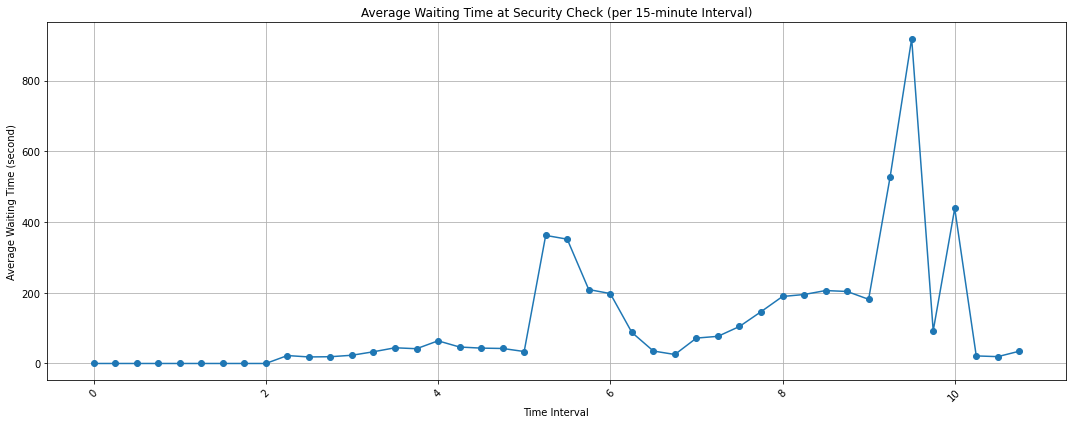

In [98]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(simulation_result_df['Time in hour'], simulation_result_df['Average Waiting Time'], marker='o')
plt.title('Average Waiting Time at Security Check (per 15-minute Interval)')
plt.xlabel('Time Interval')
plt.ylabel('Average Waiting Time (second)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()